In [1]:
#All libraries used.
from google.colab import drive
import pandas as pd
import numpy as np
import pickle as pkl
import keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
import matplotlib.pyplot as plt 


In [2]:
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/My\ Drive/73Strings

/content/gdrive/My Drive/73Strings


In [4]:
#I've already extracted the phone reviews of 12(Actually 11, one got duplicated).
#UnPickling the saved reviews
with open('phone_reviews_new_lap2.pkl','rb') as file1:
  p1 = pkl.load(file1)
with open('phone_reviews_new_lap3.pkl','rb') as file1:
  p2 = pkl.load(file1)
with open('phone_reviews_new_lap.pkl','rb') as file1:
  p3 = pkl.load(file1)
with open('phone_reviews_new_phone.pkl','rb') as file1:
  p4 = pkl.load(file1)
phone_rev = []
phone_rev.extend(p1)
phone_rev.extend(p2)
phone_rev.extend(p3)
phone_rev.extend(p4)

In [ ]:
#The first phone is duplicated, so removing it from the list
phone_rev.pop(0)

In [6]:
#Just printing the phone names
for phone in phone_rev:
  print(phone['name'])

Samsung Galaxy M31 (Ocean Blue, 6GB RAM, 64GB Storage)
Samsung Galaxy M21 (Raven Black, 6GB RAM, 128GB Storage)
Samsung Galaxy M31 (Space Black, 6GB RAM, 64GB Storage)
OPPO A5 2020 (Dazzling White, 4GB RAM, 64GB Storage) with No Cost EMI/Additional Exchange Offers
Samsung Galaxy M21 (Raven Black, 4GB RAM, 64GB Storage)
Samsung Galaxy M21 (Midnight Blue, 6GB RAM, 128GB Storage)
OnePlus 7T (Glacier Blue, 8GB RAM, Fluid AMOLED Display, 256GB Storage, 3800mAH Battery)
Redmi Note 9 (Aqua Green, 4GB RAM 128GB Storage) - 48MP Quad Camera & Full HD+ Display
Redmi 8A Dual (Sky White, 3GB RAM, 32GB Storage) – Dual Cameras & 5,000 mAH Battery
Redmi Note 8 (Moonlight White, 4GB RAM, 64GB Storage)
Redmi Note 9 Pro Max (Interstellar Black, 6GB RAM, 128GB Storage) - 64MP Quad Camera & Latest 8nm Snapdragon 720G


In [7]:
#Star ratings that has been extracted is of the form : 100% of reviews have 4 stars.
#Therefore I've used regular expression to extract just the --100-- part out of the entire sentence, to give an example..

#star_stats_refined contains the star ratings for all the phones.
#star_stats_refined_per_phone contains star ratings per phone in the order [numberOf(5*),numberOf(4*)..]
star_stats_refined = []
for item in phone_rev:
  star_stats_refined_per_phone = []
  for item2 in item['star_stats']:
    star_stats_refined_per_phone.append(re.findall("\d+%",item2)[0][:-1])
  star_stats_refined.append(star_stats_refined_per_phone)

In [9]:
star_stats_refined

[['64', '20', '5', '3', '8'],
 ['59', '23', '6', '3', '8'],
 ['64', '20', '5', '3', '8'],
 ['55', '23', '9', '3', '10'],
 ['59', '23', '6', '3', '8'],
 ['59', '23', '6', '3', '8'],
 ['72', '17', '4', '2', '6'],
 ['100'],
 ['52', '25', '9', '3', '11'],
 ['60', '24', '7', '3', '7'],
 ['60', '21', '6', '3', '10']]

In [8]:
#Further refining star_stats_refined so that every element is an integer, and star count of 5 through 1 is present for all phones.
np_star_stats_refined = np.zeros((11,5))
for i in range(len(star_stats_refined)):
  np_star_stats_refined[i][:len(star_stats_refined[i])] = star_stats_refined[i]
np_star_stats_refined

array([[ 64.,  20.,   5.,   3.,   8.],
       [ 59.,  23.,   6.,   3.,   8.],
       [ 64.,  20.,   5.,   3.,   8.],
       [ 55.,  23.,   9.,   3.,  10.],
       [ 59.,  23.,   6.,   3.,   8.],
       [ 59.,  23.,   6.,   3.,   8.],
       [ 72.,  17.,   4.,   2.,   6.],
       [100.,   0.,   0.,   0.,   0.],
       [ 52.,  25.,   9.,   3.,  11.],
       [ 60.,  24.,   7.,   3.,   7.],
       [ 60.,  21.,   6.,   3.,  10.]])

In [10]:
#Loading the trained model
model = keras.models.load_model('model_new_3.0')

In [11]:
#Tokenizer object that is to be used here for preprocessing input for prediction has to be the same as that of which was used while constructing the initial dataset for training.
#But since Tokenizer API doesn't have a random component to it, each time the Tokenizer API is fit to the same data it gives us consistent encoding for words.
#Therefore the need for pickling the tokenizer object during training phase is not necessary.

phrase_and_ids = pd.read_table('dictionary.txt',delimiter='|',names=['Phrase', 'PhraseID'])
ids_and_labels = pd.read_table('sentiment_labels.txt',delimiter='|',names=['PhraseID', 'Labels'],header=0)
df_all = phrase_and_ids.merge(ids_and_labels, how='inner', on='PhraseID')
t = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
t.fit_on_texts(df_all.iloc[:,0])

In [12]:
#Running prediction on set of reviews for each phone, and storing the result of which in phone_sent_scores list

phone_sent_scores = []
for phone in phone_rev:
  spec_dict = {}
  reviews = pd.Series(phone['reviews'])
  encoded_rev = t.texts_to_sequences(reviews)
  padded_docs = pad_sequences(encoded_rev, maxlen=56, padding='post')
  pred_score = model.predict(padded_docs)
  spec_dict['name'] = phone['name']
  spec_dict['scores'] = pred_score.reshape(1,-1)[0]
  spec_dict['revs'] = reviews
  phone_sent_scores.append(spec_dict)

In [13]:
#Constructing dataframe which contains predicted score for each user's review of each mobile
list_of_df = []
for i in phone_sent_scores:
  df_temp = pd.DataFrame()
  df_temp['Phone Name'] = pd.Series([i['name']]).repeat(len(i['scores'])).reset_index(drop=True)
  df_temp['Phone Reviews'] = i['revs']
  df_temp['Sentiment Score'] = i['scores']
  list_of_df.append(df_temp)
df_pred = pd.concat(list_of_df,ignore_index=True)

In [14]:
df_pred.to_csv('Prediction_Sentimet_Scores.csv')
df_pred.head()

,Phone Name,Phone Reviews,Sentiment Score
0,"Samsung Galaxy M31 (Ocean Blue, 6GB RAM, 64GB ...","Best camera, very good battery life, eat body ...",0.825363
1,"Samsung Galaxy M31 (Ocean Blue, 6GB RAM, 64GB ...",This is best thing you can get at this price f...,0.474976
2,"Samsung Galaxy M31 (Ocean Blue, 6GB RAM, 64GB ...",3rd class front camera. 32 MP front camera n l...,0.468452
3,"Samsung Galaxy M31 (Ocean Blue, 6GB RAM, 64GB ...","Dear Amazon & samsung you have broke my trust,...",0.409296
4,"Samsung Galaxy M31 (Ocean Blue, 6GB RAM, 64GB ...",Lets just begin with the obvious. This phone's...,0.354649


In [15]:
#Mapping the sentiment scores to 5 classes.
#Finally calculating the star rating per phone myself using the mapping defined below.

star_computed = []
def conv_cat(x):
  if(x>=0 and x<=0.1):
    return 0
  if(x>0.1 and x<=0.2):
    return 1    
  if(x>0.2 and x<=0.6):
    return 2 
  if(x>0.6 and x<=0.8):
    return 3
  if(x>0.8 and x<=1):
    return 4 
for i in phone_sent_scores:
  label = pd.Series(i['scores']).map(lambda x: conv_cat(x))
  star_computed.append(np.bincount(label)[::-1])

In [16]:
star_computed1 = np.array(star_computed)*100/np.sum(np.array(star_computed),axis=1).reshape(11,1)

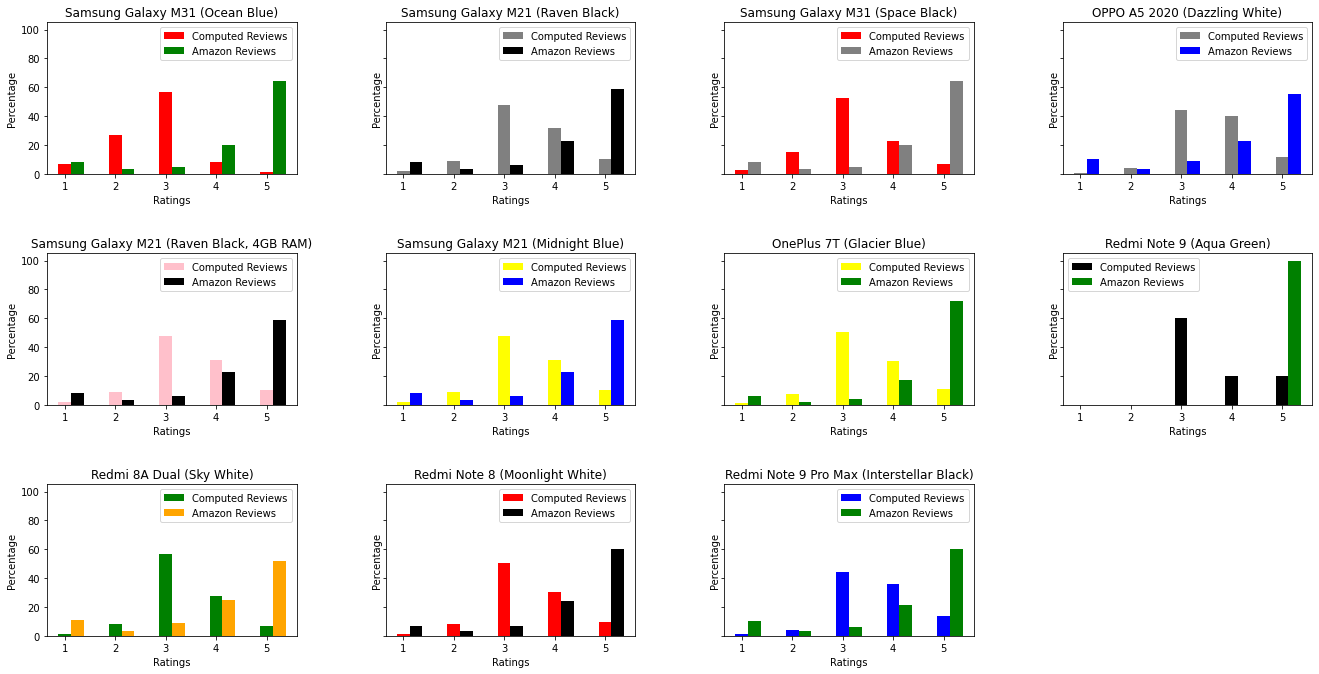

In [17]:
#Comparing the star ratings provided by Amazon.in and the one calculated by myself.

#There is a resemblance between them though, especially for ratings (1,2,4).

#One fact to be noted here is that, Amazon may not use every customer's star rating for calculating the final star ratings, they filter it based on wheather a customer
#actually bought the product, or wheather the review is related to issue of phone or not, etc.

#On the other hand I've used every customer's opinion into calculating star ratings..

#One future enhancement would be to first extract those comments that directly talks about the product and those who are verified customers, 
#and then calculate sentiment score for them alone to finalize star ratings

barWidth = 0.25
f, axs = plt.subplots(3, 4, sharey=True)

f.tight_layout()

f.set_figheight(10)
f.set_figwidth(20)

(ax1,ax2,ax3,ax4) = axs[0]
(ax5,ax6,ax7,ax8) = axs[1]
(ax9,ax10,ax11,ax12) = axs[2]
br1 = np.arange(1,6)[::-1] 
ax1.bar(br1, star_computed1[0], color ='r', width = barWidth,label='Computed Reviews') 
ax1.bar(br1+0.25,np_star_stats_refined[0] , color ='g', width = barWidth,label='Amazon Reviews') 
ax1.set_xlabel("Ratings")
ax1.set_ylabel("Percentage")
ax1.set_title("Samsung Galaxy M31 (Ocean Blue)")
ax1.legend()

ax2.bar(br1, star_computed1[1], color ='grey', width = barWidth,label='Computed Reviews') 
ax2.bar(br1+0.25,np_star_stats_refined[1] , color ='black', width = barWidth,label='Amazon Reviews') 
ax2.set_xlabel("Ratings")
ax2.set_ylabel("Percentage")
ax2.set_title("Samsung Galaxy M21 (Raven Black)")
ax2.legend()


ax3.bar(br1, star_computed1[2], color ='r', width = barWidth,label='Computed Reviews') 
ax3.bar(br1+0.25,np_star_stats_refined[2] , color ='grey', width = barWidth,label='Amazon Reviews') 
ax3.set_xlabel("Ratings")
ax3.set_ylabel("Percentage")
ax3.set_title("Samsung Galaxy M31 (Space Black)")
ax3.legend()


ax4.bar(br1, star_computed1[3], color ='grey', width = barWidth,label='Computed Reviews') 
ax4.bar(br1+0.25,np_star_stats_refined[3] , color ='blue', width = barWidth,label='Amazon Reviews') 
ax4.set_xlabel("Ratings")
ax4.set_ylabel("Percentage")
ax4.set_title("OPPO A5 2020 (Dazzling White)")
ax4.legend()

ax5.bar(br1, star_computed1[4], color ='pink', width = barWidth,label='Computed Reviews') 
ax5.bar(br1+0.25,np_star_stats_refined[4] , color ='black', width = barWidth,label='Amazon Reviews') 
ax5.set_xlabel("Ratings")
ax5.set_ylabel("Percentage")
ax5.set_title("Samsung Galaxy M21 (Raven Black, 4GB RAM)")
ax5.legend()

ax6.bar(br1, star_computed1[5], color ='yellow', width = barWidth,label='Computed Reviews') 
ax6.bar(br1+0.25,np_star_stats_refined[5] , color ='blue', width = barWidth,label='Amazon Reviews') 
ax6.set_xlabel("Ratings")
ax6.set_ylabel("Percentage")
ax6.set_title("Samsung Galaxy M21 (Midnight Blue)")
ax6.legend()

ax7.bar(br1, star_computed1[6], color ='yellow', width = barWidth,label='Computed Reviews') 
ax7.bar(br1+0.25,np_star_stats_refined[6] , color ='g', width = barWidth,label='Amazon Reviews') 
ax7.set_xlabel("Ratings")
ax7.set_ylabel("Percentage")
ax7.set_title("OnePlus 7T (Glacier Blue)")
ax7.legend()

ax8.bar(br1, star_computed1[7], color ='black', width = barWidth,label='Computed Reviews') 
ax8.bar(br1+0.25,np_star_stats_refined[7] , color ='g', width = barWidth,label='Amazon Reviews') 
ax8.set_xlabel("Ratings")
ax8.set_ylabel("Percentage")
ax8.set_title("Redmi Note 9 (Aqua Green)")
ax8.legend()

ax9.bar(br1, star_computed1[8], color ='g', width = barWidth,label='Computed Reviews') 
ax9.bar(br1+0.25,np_star_stats_refined[8] , color ='orange', width = barWidth,label='Amazon Reviews') 
ax9.set_xlabel("Ratings")
ax9.set_ylabel("Percentage")
ax9.set_title("Redmi 8A Dual (Sky White)")
ax9.legend()

ax10.bar(br1, star_computed1[9], color ='r', width = barWidth,label='Computed Reviews') 
ax10.bar(br1+0.25,np_star_stats_refined[9] , color ='black', width = barWidth,label='Amazon Reviews') 
ax10.set_xlabel("Ratings")
ax10.set_ylabel("Percentage")
ax10.set_title("Redmi Note 8 (Moonlight White)")
ax10.legend()

ax11.bar(br1, star_computed1[10], color ='blue', width = barWidth,label='Computed Reviews') 
ax11.bar(br1+0.25,np_star_stats_refined[10] , color ='g', width = barWidth,label='Amazon Reviews') 
ax11.set_xlabel("Ratings")
ax11.set_ylabel("Percentage")
ax11.set_title("Redmi Note 9 Pro Max (Interstellar Black)")
ax11.legend()

ax12.set_visible(False)

plt.show() 
